In [1]:
!pip install -r requirements.txt
!pip install -U sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring tensorflow-macos: markers 'sys_platform == "darwin" and "ARM" in platform_version' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "darwin" and "ARM" not in platform_version' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from transformers import  TFDebertaV2Model, DebertaV2TokenizerFast
from tensorflow.keras import callbacks
from tensorflow.keras import layers, Input, Sequential, Model

# Configuration

In [3]:
class config:
    base_dir = "/kaggle/working/"
  
    # dataset path   
    train_dataset_path='/content/train.csv'
    test_dataset_path = '/content/test.csv'
    
    #tokenizer params
    truncation = True
    padding = True #'max_length'
    max_length = 512
    
    # model params
    train_col='full_text'
    model_name = "microsoft/deberta-v2-xlarge"
    target_cols = ['cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions']

# Load the Tokenizer
first, we define a function to tokenize the text from a dataframe

In [4]:
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v2-xlarge")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
def tokenize (df):
    texts=list(df[config.train_col])
    tokenized=tokenizer(texts,
                       padding=config.padding,
                       truncating=True,
                       max_length=config.max_length)
    tokenized["labels"]= [df[column] for column in config.target_cols]
    tokenized['length'] = len(tokenized['input_ids'])
    
    return tokenized

# Load the data

In [6]:
data=pd.read_csv('/content/train.csv').copy()
texts=data[config.train_col]
targets=data[config.target_cols]
train_texts, val_texts, train_targets, val_targets=train_test_split(texts, targets, test_size=0.3)

In [ ]:
train_targets.shape

In [7]:
data_test_texts = pd.read_csv('/content/test.csv').copy()
test_texts = data_test_texts[config.train_col]

# Convert the data into a tokenized form
Here we want the tokens to be read by a tf.keras model

In [8]:
tokenized_train_texts = tokenizer(list(train_texts), return_tensors='tf',truncation=config.truncation, padding=config.padding)
tokenized_val_texts = tokenizer(list(val_texts), return_tensors='tf', truncation=config.truncation, padding=config.padding)

In [9]:
tokenized_test_texts = tokenizer(list(test_texts), return_tensors='tf', truncation=config.truncation, padding=config.padding)

# Defining the model
### Defining the loss function

In [14]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

### Model architecture
Here we use the output of the pretrained DeBerta model as an input of a dense intermediate layer, then we input the result in the linear regression parallele output layers, for each target.

In [10]:
input_ids = Input(shape=((512)),dtype='int32')

In [11]:
# Import the needed model(Bert, Roberta or DistilBert) with output_hidden_states=True
transformer_model = TFDebertaV2Model.from_pretrained('microsoft/deberta-v2-xlarge', output_hidden_states=True, return_dict=True)
transformer_model.trainable = False

input_ids = Input(shape=((512)),dtype='int32', name='input_ids')
attention_mask = Input(shape=((512)), dtype='int32', name='attention_mask')

transformer = transformer_model(dict(input_ids=input_ids,attention_mask=attention_mask))    
hidden_states = transformer[0] # get output_hidden_states


# Add a layer maxpool 1D
pooling_layer = layers.GlobalMaxPooling1D()(hidden_states)

# Now we can use selected_hiddes_states as we want
last_hidden_layer = layers.Dense(64, activation='relu')(pooling_layer)

# Defining the regression layer
cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(last_hidden_layer)
syntax_output=layers.Dense(1, activation="linear", name="syntax")(last_hidden_layer)
vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(last_hidden_layer)
phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(last_hidden_layer)
grammar_output=layers.Dense(1, activation="linear", name="grammar")(last_hidden_layer)
conventions_output=layers.Dense(1, activation="linear", name="conventions")(last_hidden_layer)

# output in a list
output= [cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output]

#Assembling the model
model = Model(inputs = [input_ids, attention_mask], outputs = output)
model.summary()

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v2-xlarge.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_deberta_v2_model (TFDeberta  TFBaseModelOutput(l  884593152  ['attention_mask[0][0]',         
 V2Model)                       ast_hidden_state=(N               'input_ids[0][0]']              
                                one, 512, 1536),                                                  
                                 hidden_states=((No                                           

In [15]:
# Compile the model 
model.compile(loss='mse', optimizer='adam',loss_weights=[1/6 for i in range(6)], metrics= root_mean_squared_error)

In [16]:
# Fit the model
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x={'input_ids':tokenized_train_texts['input_ids'],
                        'attention_mask':tokenized_train_texts['attention_mask']},
                    y=train_targets,epochs=50,batch_size=6,validation_split=0.2, callbacks=[es],
          verbose=1)

Epoch 1/50


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


365/365 [==============================] - 638s 2s/step - loss: 0.7317 - cohesion_loss: 0.7325 - syntax_loss: 0.7143 - vocabulary_loss: 0.7154 - phraseology_loss: 0.8082 - grammar_loss: 0.6110 - conventions_loss: 0.8089 - cohesion_root_mean_squared_error: 0.7442 - syntax_root_mean_squared_error: 0.7367 - vocabulary_root_mean_squared_error: 0.7086 - phraseology_root_mean_squared_error: 0.7332 - grammar_root_mean_squared_error: 0.6841 - conventions_root_mean_squared_error: 0.7538 - val_loss: 0.4672 - val_cohesion_loss: 0.3420 - val_syntax_loss: 0.3279 - val_vocabulary_loss: 0.4419 - val_phraseology_loss: 0.6040 - val_grammar_loss: 0.6543 - val_conventions_loss: 0.4332 - val_cohesion_root_mean_squared_error: 0.5397 - val_syntax_root_mean_squared_error: 0.5311 - val_vocabulary_root_mean_squared_error: 0.6018 - val_phraseology_root_mean_squared_error: 0.6977 - val_grammar_root_mean_squared_error: 0.7312 - val_conventions_root_mean_squared_error: 0.5981
Epoch 2/50
365/365 [==================

In [17]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)

In [28]:
# Save to CSV
hist_csv_file = 'deberta_v2_xlarge_history.csv'
with open(hist_csv_file, mode='w') as deberta_v2_xlarge_history:
    hist_df.to_csv(deberta_v2_xlarge_history)

In [19]:
tokenized_test_text = tokenizer(list(test_texts), return_tensors='tf',truncation=config.truncation, padding=config.padding)

In [20]:
 # Make predictions on the test set
test_predictions = model.predict({'input_ids':tokenized_test_texts['input_ids'], 'attention_mask':tokenized_test_texts['attention_mask']})

# Create a list of dictionaries with the predictions
predictions_list = []
for i in range(len(test_predictions[0])):
    prediction_dict = {'cohesion': test_predictions[0][i],
                       'syntax': test_predictions[1][i],
                       'vocabulary': test_predictions[2][i],
                       'phraseology': test_predictions[3][i],
                       'grammar': test_predictions[4][i],
                       'conventions': test_predictions[5][i]}
    predictions_list.append(prediction_dict)

# Convert the list to a dataframe
predictions_df = pd.DataFrame(predictions_list)



1/1 [==============================] - 12s 12s/step


In [21]:
# Save the dataframe to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/mathieu_first_deberta_v2_xlarge_model


In [23]:
# Save the model weigths on google drive
model.save('/content/drive/MyDrive/mathieu_first_deberta_v2_xlarge_model/mathieu_first_deberta_v2_xlarge_model.h5')
model.save_weights('/content/drive/MyDrive/mathieu_first_deberta_v2_xlarge_model/mathieu_first_deberta_v2_xlarge_model_weights.h5')


In [ ]:
# Load the weigths on the notebook
model.load_weights('/content/drive/MyDrive/mathieu_first_deberta_v2_xlarge_model/mathieu_first_deberta_v2_xlarge_model_weights.h5')

In [24]:
# Model evaluation
model_eval = model.evaluate(x={'input_ids':tokenized_val_texts['input_ids'], 'attention_mask':tokenized_val_texts['attention_mask']},
                            y = val_targets)

37/37 [==============================] - 40s 1s/step - loss: 0.2649 - cohesion_loss: 0.2593 - syntax_loss: 0.2639 - vocabulary_loss: 0.2629 - phraseology_loss: 0.2663 - grammar_loss: 0.2627 - conventions_loss: 0.2744 - cohesion_root_mean_squared_error: 0.4754 - syntax_root_mean_squared_error: 0.4773 - vocabulary_root_mean_squared_error: 0.4784 - phraseology_root_mean_squared_error: 0.4822 - grammar_root_mean_squared_error: 0.4786 - conventions_root_mean_squared_error: 0.4867


In [25]:
model_eval

[0.26490601897239685,
 0.2592943012714386,
 0.26393553614616394,
 0.2629151940345764,
 0.26625683903694153,
 0.26265308260917664,
 0.2743808329105377,
 0.47541365027427673,
 0.47731462121009827,
 0.4784228801727295,
 0.4821668267250061,
 0.47862595319747925,
 0.48673805594444275]

In [26]:
# Dataviz
def plot_history(history, title='', axs=None, exp_name=""):

    #compute new metrics and add in 'history.history'
    metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    scores=['loss','root_mean_squared_error']
    history.history['MCRMSE']=[]
    history.history['val_MCRMSE']=[]
    for epoch in range(len(history.history['loss'])):
      mcrmse=0
      val_mcrmse=0
      for m in metrics:
        mcrmse +=history.history[f'{m}_root_mean_squared_error'][epoch]
        val_mcrmse +=history.history[f'val_{m}_root_mean_squared_error'][epoch]
      history.history['MCRMSE'].append(mcrmse/len(metrics))
      history.history['val_MCRMSE'].append(val_mcrmse/len(metrics))

    if axs is not None:
        ax1, ax2 = axs
    else:
        f, ax = plt.subplots(7, 2, figsize=(12, 2*7))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax[0][0].plot(history.history['loss'], label='train' + exp_name)
    ax[0][0].plot(history.history['val_loss'], label='val' + exp_name)
    ax[0][0].set_title('loss')
    ax[0][0].legend()
   
    ax[0][1].plot(history.history['MCRMSE'], label='train' + exp_name)
    ax[0][1].plot(history.history['val_MCRMSE'], label='val' + exp_name)
    ax[0][1].set_title('MCRMSE')
    ax[0][1].legend()
    i=0
    for m in metrics:
      j=0
      i+=1
      for s in scores:
        ax[i][j].plot(history.history[f'{m}_{s}'], label='train' + exp_name)
        ax[i][j].plot(history.history[f'val_{m}_{s}'], label='val' + exp_name)
        ax[i][j].set_title(f'{m}_{s}')
        ax[i][j].legend()
        j+=1
        
    return ax

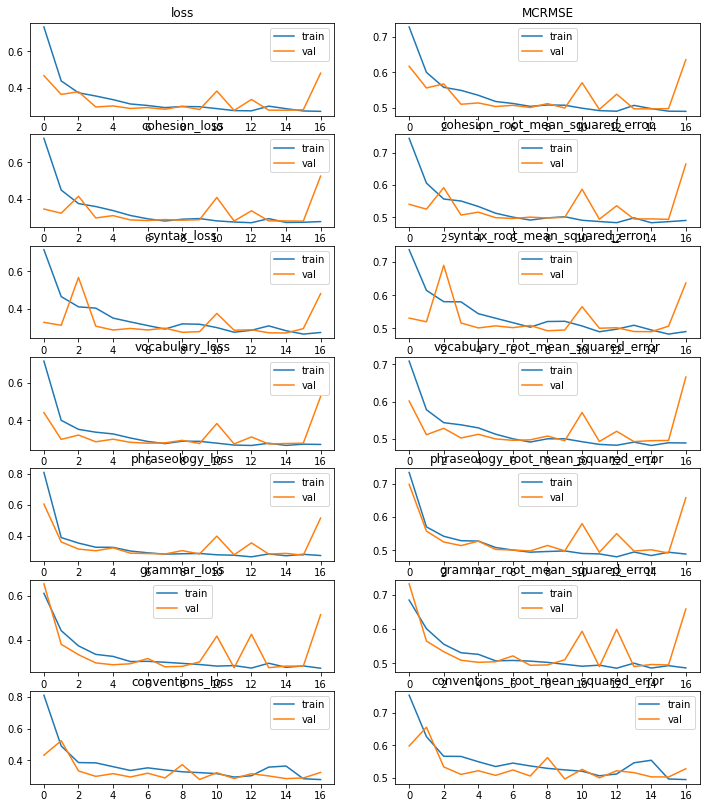

In [27]:
plot_history(history);
